In [72]:
import scipy.linalg as LA
import numpy as np
import math, scipy, time
from scipy.linalg import eigh

import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [73]:
# This code follows ref Phys. Rev. B 93, 115110 (2016)
# for a real-space mean-field



#### PARAMETERS #####

Lenar = np.arange(1,10) # system size

#### Code begings ####

# string manipulation for filename

def rp(txt):
    return (txt.replace('.','p')).replace('-','m')


# Lattice vectors

a1 = np.array([1,0])
a2 = np.array([0,1])


# Hamiltonian construction : hopping Hamiltonian

def dvec(rij):
    r = np.zeros(3)
    r[0:2] = rij
    r[2] = 0.0
    z = np.array([0,0,1])
    return np.cross(z,r)[0:2]

# define Pauli Matrices
sig0 = np.array([[1,0],[0,1]]).astype(complex)
sigx = np.array([[0,1],[1,0]]).astype(complex)
sigy = np.array([[0. + 0.j, 0. - 1.j],[0. + 1.j, 0. + 0.j]]).astype(complex)
sigz = np.array([[1,0],[0,-1]]).astype(complex)



In [74]:
delta_stag = 0.0

L = 2
U = 0.5
lamda = 0.0


tstart = time.time()


Nsites = int(L*L)
Nbands = int(6*Nsites)

pmn = np.zeros([Nsites,2])

for m in range(L):
    for n in range(L):
        p = m + L*n
        pmn[p] = [m,n]


# adjacency matrix
if L>1:
    cvectr = np.zeros([L,1])
    cvectr[1]=1
    cvectr[L-1]=1
    offdi = LA.circulant(cvectr)
    I = np.eye(L)	
    Adj = np.kron(offdi,I) + np.kron(I,offdi)
else:
    Adj = np.ones([1,1])

In [75]:
# given p1, p2, can you tell me what rijs enter?

rijInfo = []

for p1 in range(Nsites):
    for p2 in range(Nsites):
        if Adj[p1,p2] > 0.0:

            # get coords for p1
            [m1,n1] = pmn[p1]
            r1 = np.multiply(a1,m1/float(L)) + np.multiply(a2,n1/float(L))

            #get coords for p2
            [m2,n2] = pmn[p2]
            r2 = np.multiply(a1,m2/float(L)) + np.multiply(a2,n2/float(L))

            # make images
            im = [-1,0,1]

            for im1 in im:
                for im2 in im:
                    rij = r1-r2 + np.multiply(a1,im1) + np.multiply(a2,im2)
                    if ( abs(LA.norm(rij) - np.float(1.0/(L)) ) < 1.e-3):
                        rijInfo.append([p1,p2,rij[0],rij[1]])

rijInfo = np.array(rijInfo)

tcp1 = time.time()
print('\nCP1: Lattice, time taken %fs \n'%(tcp1-tstart))



CP1: Lattice, time taken 0.710010s 




CP2: Tight-Binding, time taken 0.769472s 

0j


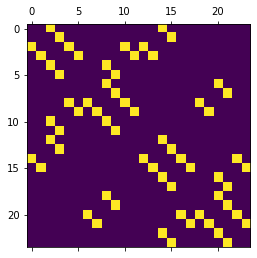

In [76]:
# make Hopping Hamiltonian

# make the 6x6 hopping matrix
#    liebHop = [[0,1,0],[1,0,1],[0,1,0]]

def liebHop_delta(dist):

    tplus = 1.0 + delta_stag
    tmnus = 1.0 - delta_stag

    # cases:
    # diagonal
    if (LA.norm(np.asarray(dist))==0.0):
        reMat = [[0,tplus,0],[tplus,0,tplus],[0,tplus,0]]
    # +x
    elif (dist[0] > 0.0):
        reMat = [[0,0,0],[0,0,0],[0,tmnus,0]] 
    # -x
    elif (dist[0] < 0.0):
        reMat = [[0,0,0],[0,0,tmnus],[0,0,0]]

    # +y
    elif (dist[1] > 0.0):
        reMat = [[0,tmnus,0],[0,0,0],[0,0,0]]

    # -y
    elif (dist[1] < 0.0):
        reMat = [[0,0,0],[tmnus,0,0],[0,0,0]]

    # none
    else:
        print(rij,'error in rij')

    return np.asmatrix(reMat)


# make the 6x6 SOC hop matrix
def hopMatSOC(dist):
    d12 = dvec(dist)
    d_dot_sigma = d12[0]*sigx + d12[1]*sigy
    return np.kron(liebHop_delta(dist),1j*d_dot_sigma)

def hopMat(dist):
    return np.kron(liebHop_delta(dist),np.eye(2))

Ohop = np.zeros([Nbands,Nbands]).astype(complex)
SOChop = np.zeros([Nbands,Nbands]).astype(complex)


for itr in range(len(rijInfo[:,0])):

    p1 = rijInfo[itr,0]
    p2 = rijInfo[itr,1]
    rij = rijInfo[itr,2:4]

    i = int(6*p1)
    j = int(6*p2)

    Ohop[i:i+6,j:j+6] += hopMat(rij)

    SOChop[i:i+6,j:j+6] += hopMatSOC(rij)

# diagonal pieces
for site in range(Nsites):
    i = 6*site
    Ohop[i:i+6,i:i+6] += hopMat([0,0])

tcp2 = time.time()
print('\nCP2: Tight-Binding, time taken %fs \n'%(tcp2-tcp1))

print(np.trace( np.asmatrix(Ohop).getH() - Ohop ))


en, w = LA.eig(Ohop)

#plt.hist(en, bins = 100)
plt.matshow(np.real(Ohop))
#plt.show()

In [96]:
def MFInt(MFVec):
	MFHam1 = np.zeros([Nbands,Nbands])


	for site in range(Nsites):
		print(site,Nsites)
		mfsite = MFVec[site, :]
        
		nupA, ndownA, SplusA = mfsite[0:3]
		nupB, ndownB, SplusB = mfsite[3:6]
		nupC, ndownC, SplusC = mfsite[6:9]

		mfmat = np.asmatrix([[ndownA, -np.conj(SplusA), 0, 0, 0, 0],\
				[-SplusA, nupA, 0, 0, 0, 0],\
				[0, 0, ndownB, -np.conj(SplusB), 0, 0],\
				[0, 0, -SplusB, nupB, 0, 0],\
				[0, 0, 0, 0, ndownC, -np.conj(SplusC)],\
				[0, 0, 0, 0, -SplusC, nupC]])
				
		i = int(6*site)
		MFHam1[i:i+6, i:i+6] = mfmat

	return MFHam1

def giveMat(site, mfindex):
	gm = np.zeros([Nbands,Nbands])
	
	i = 6*site

	mfV = [[0,0],[1,1],[0,1],[2,2],[3,3],[2,3],[4,4],[5,5],[4,5]]

	matD = np.zeros([6,6])
	mindex = mfV[mfindex]
	matD[mindex[0],mindex[1]] = 1.0

	gm[i:i+6, i:i+6 ] = matD

	return np.asmatrix(gm)


def classicalEn(MFVec):
	cen = 0.0
	for i in range(Nsites):
		mfsite = MFVec[i,:]
		nupA, ndownA, SplusA = mfsite[0:3]
		nupB, ndownB, SplusB = mfsite[3:6]
		nupC, ndownC, SplusC = mfsite[6:9]

		spsm = np.abs(SplusA)**2 + np.abs(SplusB)**2 + np.abs(SplusC)**2
		nund = nupA*ndownA + nupB*ndownB + nupC*ndownC

		cen += spsm - nund

	Ham = Ohop + lamda*SOChop + U*MFInt(MFVec)
	en, ev = np.linalg.eigh(Ham)

	return np.real((U*cen + np.sum( en[en < 0.0] ))/Nsites)

def netMag(MFVec):
	netMA = np.asarray([0.0,0.0,0.0]).astype(complex)
	netMB = np.asarray([0.0,0.0,0.0]).astype(complex)
	netMC = np.asarray([0.0,0.0,0.0]).astype(complex)
	for i in range(Nsites):
		mfsite = MFVec[i,:]
		nupA, ndownA, SplusA = mfsite[0:3]
		nupB, ndownB, SplusB = mfsite[3:6]
		nupC, ndownC, SplusC = mfsite[6:9]

		sA = np.asarray([np.real(SplusA), np.imag(SplusA), 0.5*(nupA-ndownA)])
		sB = np.asarray([np.real(SplusB), np.imag(SplusB), 0.5*(nupB-ndownB)])
		sC = np.asarray([np.real(SplusC), np.imag(SplusC), 0.5*(nupC-ndownC)])

		netMA += sA
		netMB += sB
		netMC += sC

	return [LA.norm(netMA)/Nsites, LA.norm(netMB)/Nsites, LA.norm(netMC)/Nsites]

def MFHaml(MFVec,U):
    return Ohop + lamda*SOChop + U*MFInt(MFVec) 

def MFExpValue(MFVec):

	Ham = Ohop + lamda*SOChop + U*MFInt(MFVec)

	eigenValues, eigenVectors = np.linalg.eigh(Ham)

	idx = eigenValues.argsort()[:]  
	en = eigenValues[idx]
	umat = np.asmatrix(eigenVectors[:,idx])

	MFout = np.zeros([Nsites,9]).astype(complex)

#	udu = np.dot(umat.getH(), umat)
#	uud = np.dot(umat, umat.getH())
#	print('tr', np.round(np.trace(uud-udu),2),'\n')

	for site in range(Nsites):
		for mfindex in range(9):

			mfmat = giveMat(site, mfindex)

			UmfU = np.dot(np.dot(umat.getH(), mfmat), umat)

			# T=0 means sum over negative energies
			sm = 0.0
			indx = np.arange(0,Nbands)[(en<=0.0)]
			for nn in indx:
				sm += UmfU[nn,nn]

			MFout[site,mfindex] = sm


#	print(classicalEn(MFVec), netMag(MFVec), DeltaConf(MFVec,MFout))

	return MFout

def DeltaConf(mf1, mf2):
	err = 0.0
	for i in range(Nsites):
		mfsite = mf1[i,:]
		nupA, ndownA, SplusA = mfsite[0:3]
		nupB, ndownB, SplusB = mfsite[3:6]
		nupC, ndownC, SplusC = mfsite[6:9]
		sA1 = np.asarray([np.real(SplusA), np.imag(SplusA), 0.5*(nupA-ndownA)])
		sB1 = np.asarray([np.real(SplusB), np.imag(SplusB), 0.5*(nupB-ndownB)])
		sC1 = np.asarray([np.real(SplusC), np.imag(SplusC), 0.5*(nupC-ndownC)])

		mfsite = mf2[i,:]
		nupA, ndownA, SplusA = mfsite[0:3]
		nupB, ndownB, SplusB = mfsite[3:6]
		nupC, ndownC, SplusC = mfsite[6:9]
		sA2 = np.asarray([np.real(SplusA), np.imag(SplusA), 0.5*(nupA-ndownA)])
		sB2 = np.asarray([np.real(SplusB), np.imag(SplusB), 0.5*(nupB-ndownB)])
		sC2 = np.asarray([np.real(SplusC), np.imag(SplusC), 0.5*(nupC-ndownC)])

		err += LA.norm(sA1-sA2) + LA.norm(sB1-sB2) + LA.norm(sC1-sC2)

	return err/Nsites


In [97]:
seed = np.ones([Nsites,9])
for i in range(Nsites):
    seed[i,:] = np.ones(9)
    seed[i,2] = 1.0
    seed[i,5] = -1.0
    seed[i,8] = 1.0

In [98]:
seed

array([[ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.]])

0 4
1 4
2 4
3 4


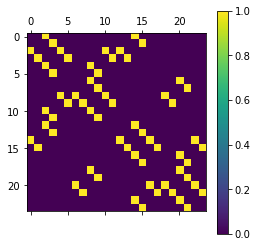

In [99]:
lamda = 0.0
U = 0.0
plt.matshow(np.real(MFHaml(seed,U)))
plt.colorbar()

0 4
1 4
2 4
3 4


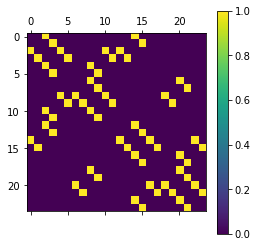

In [104]:
lamda = 0.0
U = 0.0
plt.matshow(np.real(MFHaml(seed,U)))
plt.colorbar()

0 4
1 4
2 4
3 4


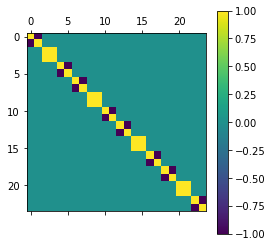

In [102]:
lamda = 0.0
U = 1.0
plt.matshow(np.real(MFInt(seed)))
plt.colorbar()